# Handle Data

In [1]:
pip install dlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 47.2 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for dlib: filename=dlib-19.24.4-cp310-cp310-linux_x86_64.whl size=3327192 sha256=3a24aaecac1614087bfeccb39b271e9ed7e6efc6155d7a989dce7d1aafe95584
  Stored in directory: /root/.cache/pip/wheels/08/5e/55/a7db8d57920eb2c2aa41c36dc4c6d3cd12323865de191a7211
Successfully built dlib
Note: you may need to restart the kernel to use updated packages.


In [2]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np
import torch
import dlib
import cv2 as cv

## XML Tree to get data

In [3]:
import xml.etree.ElementTree as ET
tree = ET.parse('/kaggle/input/ibug-300w-large-face-landmark-dataset/ibug_300W_large_face_landmark_dataset/labels_ibug_300W.xml')

In [4]:
root = tree.getroot()

for child in root:
    print(f"{child.tag} + {child.attrib}")

name + {}
comment + {}
images + {}


## Dataset

In [5]:
import torch
from PIL import Image
from torch.utils.data import Dataset
from tqdm import tqdm
import os

class IDataset:
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.images, self.landmarks = self.generateData(self.data_dir)

    def sample_image(self, image):
        """
        Create a dictionary containing image details.

        Args:
            image: An XML element containing image data.

        Returns:
            A dictionary with image attributes including:
            - filename (str)
            - width (int)
            - height (int)
            - box_top (int)
            - box_left (int)
            - box_width (int)
            - box_height (int)
            - landmarks (np.ndarray of tuples): Each tuple contains (x, y) coordinates of a landmark.
        """

        image_result = {}
        image_result['filename'] = image.attrib['file']
        image_result['width'] = int(image.attrib['width'])
        image_result['height'] = int(image.attrib['height'])

        box = image.find('box')
        image_result['box_top'] = int(box.attrib['top'])
        image_result['box_left'] = int(box.attrib['left'])
        image_result['box_width'] = int(box.attrib['width'])
        image_result['box_height'] = int(box.attrib['height'])

        # set up landmarks
        landmarks = np.array([[float(part.attrib["x"]), float(part.attrib["y"])] for part in box])
        image_result['landmarks'] = landmarks

        return image_result

    def create_samples_xml(self, xml_file_path):
        tree = ET.parse(xml_file_path)
        root = tree.getroot()
        images = root.find('images')
        samples: list[dict] = [self.sample_image(image) for image in images]
        return samples

    def get_data(self, samples, root_dir):
        images = []
        landmarks_list = []
        samples = tqdm(samples)
        for sample in samples:
            image_path = os.path.join(root_dir, sample['filename'])
            if os.path.exists(image_path):
                image = Image.open(image_path).convert("RGB")
                width = sample['width']
                height = sample['height']
                box_left = sample["box_left"]
                box_top = sample["box_top"]
                box_width = sample["box_width"]
                box_height = sample["box_height"]
                landmarks = sample['landmarks']
                crop_image = image.crop((box_left, box_top, box_left + box_width, box_top + box_height))
                landmarks -= np.array([box_left, box_top])
                images.append(crop_image)
                landmarks_list.append(landmarks)
        return images, landmarks_list

    def generateData(self, path):
        samples = self.create_samples_xml(path)
        images, landmarks = self.get_data(samples, os.path.dirname(path))
        return images, landmarks

class LandmarkData(Dataset):
    def __init__(self, images: torch.Tensor, landmarks: torch.Tensor):
        self.images = images
        self.landmarks = landmarks

    def __len__(self):
        return len(self.landmarks)

    def __getitem__(self, idx):
        return self.images[idx], self.landmarks[idx]

In [6]:
data_train = IDataset("/kaggle/input/ibug-300w-large-face-landmark-dataset/ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml")
data_test = IDataset("/kaggle/input/ibug-300w-large-face-landmark-dataset/ibug_300W_large_face_landmark_dataset/labels_ibug_300W_test.xml")

100%|██████████| 1008/1008 [00:25<00:00, 39.81it/s]


## Data Agument

In [10]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np
import torch

transform_train = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.Resize(height=256, width=256, always_apply=True),
    A.RandomCrop(height=224, width=224, always_apply=True),
    A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
#     A.Cutout(num_holes=8, max_h_size=18, max_w_size=18, p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))


transform_test = A.Compose([
    A.Resize(height=256, width=256, always_apply=True),
    A.CenterCrop(height=224, width=224, always_apply=True),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))


class DataAugment():
    def __init__(self):
        self.transform_train = transform_train
        self.transform_test = transform_test
        self.images = None
        self.landmarks = None

    def norm_transform_dataset(self, images, landmarks, transform):
        final_images = []
        final_landmarks = []

        for i in tqdm(range(len(images))):
            img = images[i]
            ldm = landmarks[i]

            img = np.array(img)

            # transform
            transformed = transform(image=img, keypoints=ldm)
            transformed_img = transformed['image']
            transformed_lmd = transformed['keypoints']

            # normalize
            color_channels, height, width = transformed_img.shape
            transformed_lmd = transformed_lmd / np.array([width, height]) - 0.5
            transformed_lmd = torch.tensor(transformed_lmd, dtype=torch.float32)

            final_images.append(transformed_img)
            final_landmarks.append(transformed_lmd)

        self.images = final_images
        self.landmarks = final_landmarks

        return final_images, final_landmarks

    def finish_data_tensor(self, images, landmarks):
        final_images_train_converted = torch.stack([tensor.permute(1, 2, 0) for tensor in images])
        final_landmarks_train = np.array(landmarks)

        return final_images_train_converted, final_landmarks_train

## Agument Data

In [11]:
DA = DataAugment()
# train data
images_train, landmarks_train = data_train.images, data_train.landmarks
images_train_transform, landmarks_train_transform = DA.norm_transform_dataset(images_train, landmarks_train,
                                                                               DA.transform_train)
train_set_images, train_set_landmarks = images_train_transform, landmarks_train_transform

# test data
images_test, landmarks_test = data_test.images, data_test.landmarks
images_test_transform, landmarks_test_transform = DA.norm_transform_dataset(images_test, landmarks_test, DA.transform_test)
test_set_images, test_set_landmarks = images_test_transform, landmarks_test_transform

100%|██████████| 1008/1008 [00:02<00:00, 388.48it/s]


## Data for model

In [13]:
from torch.utils.data import DataLoader
# trains data
data_train = LandmarkData(train_set_images, train_set_landmarks)
train_set = DataLoader(data_train, batch_size=32, shuffle=True, num_workers=4)
# test data
data_test = LandmarkData(test_set_images, test_set_landmarks)
test_set = DataLoader(data_test, batch_size=32, shuffle=False, num_workers=4)

# Model

## Model EfficentnetB0

In [15]:
import torch.nn as nn
import torchvision.models as models
class EfficientNetB0(nn.Module):
    def __init__(self, num_points):
        super(EfficientNetB0, self).__init__()
        self.num_points = num_points
        self.model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        self.model.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(self.model.classifier[1].in_features, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, num_points * 2)
        )

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, self.num_points, 2)
        return x

## Train function

In [16]:
from torch.optim import Adam
from torch.nn import MSELoss

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def train_model(model, train_data, test_data, num_epochs=35):
    best_test_loss = 1e9
    train_loss_history = []
    test_loss_history = []
    loss_fn = MSELoss()
    optimizer = Adam(params=model.model.classifier.parameters(), lr=1e-3)
    for epoch in range(num_epochs):
        # Train model
        model.train()
        running_loss = 0.0
        train_pbar = tqdm(train_data)

        for images, landmarks in train_pbar:
            images = images.to(DEVICE)
            landmarks = landmarks.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, landmarks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            train_pbar.set_postfix({"Train loss": loss.item()})

        train_loss = running_loss / len(train_data.dataset)
        train_loss_history.append(train_loss)

        # test model
        model.eval()
        test_loss = 0.0
        test_pbar = tqdm(test_data)

        with torch.no_grad():
            for images, landmarks in test_pbar:
                images = images.to(DEVICE)
                landmarks = landmarks.to(DEVICE)

                outputs = model(images)
                loss = loss_fn(outputs, landmarks)

                test_loss += loss.item() * images.size(0)
                test_pbar.set_postfix({"Test loss": loss.item()})

        test_loss = test_loss / len(test_data.dataset)
        test_loss_history.append(test_loss)

        print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print("Model saving ...")

    return model


In [47]:
model = EfficientNetB0(68)
model.to(DEVICE)

EfficientNetB0(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_

In [20]:
for param in model.model.parameters():
    param.requires_grad = False

for param in model.model.classifier.parameters():
    param.requires_grad = True
#     summary(model, input_size=(3, 224, 224))
#     model.load_state_dict(torch.load('best_model_2.pth'))
model = train_model(model, train_set, test_set, 2)

100%|██████████| 32/32 [00:02<00:00, 15.07it/s, Test loss=0.00829]


Epoch 1, Train Loss: 0.0207, Test Loss: 0.0085
Model saving ...


100%|██████████| 32/32 [00:02<00:00, 15.17it/s, Test loss=0.00754]

Epoch 2, Train Loss: 0.0132, Test Loss: 0.0068
Model saving ...


In [22]:
model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))
model = train_model(model, train_set, test_set, 50)

100%|██████████| 32/32 [00:02<00:00, 15.46it/s, Test loss=0.00667]


Epoch 1, Train Loss: 0.0096, Test Loss: 0.0061
Model saving ...


100%|██████████| 32/32 [00:02<00:00, 15.55it/s, Test loss=0.00647]


Epoch 2, Train Loss: 0.0095, Test Loss: 0.0060
Model saving ...


100%|██████████| 32/32 [00:02<00:00, 15.60it/s, Test loss=0.00647]


Epoch 3, Train Loss: 0.0094, Test Loss: 0.0061


100%|██████████| 32/32 [00:02<00:00, 15.45it/s, Test loss=0.0066] 


Epoch 4, Train Loss: 0.0094, Test Loss: 0.0061


100%|██████████| 32/32 [00:02<00:00, 15.52it/s, Test loss=0.00624]


Epoch 5, Train Loss: 0.0094, Test Loss: 0.0061


100%|██████████| 32/32 [00:02<00:00, 15.58it/s, Test loss=0.00626]


Epoch 6, Train Loss: 0.0094, Test Loss: 0.0061


100%|██████████| 32/32 [00:02<00:00, 15.36it/s, Test loss=0.00672]


Epoch 7, Train Loss: 0.0093, Test Loss: 0.0060


100%|██████████| 32/32 [00:02<00:00, 15.50it/s, Test loss=0.00611]


Epoch 8, Train Loss: 0.0092, Test Loss: 0.0060


100%|██████████| 32/32 [00:02<00:00, 14.73it/s, Test loss=0.00621]


Epoch 9, Train Loss: 0.0092, Test Loss: 0.0060
Model saving ...


100%|██████████| 32/32 [00:02<00:00, 15.57it/s, Test loss=0.00673]


Epoch 10, Train Loss: 0.0092, Test Loss: 0.0060
Model saving ...


100%|██████████| 32/32 [00:02<00:00, 15.60it/s, Test loss=0.00578]


Epoch 11, Train Loss: 0.0091, Test Loss: 0.0060


100%|██████████| 32/32 [00:02<00:00, 15.28it/s, Test loss=0.00638]


Epoch 12, Train Loss: 0.0092, Test Loss: 0.0061


100%|██████████| 32/32 [00:02<00:00, 15.54it/s, Test loss=0.00655]


Epoch 13, Train Loss: 0.0092, Test Loss: 0.0060


100%|██████████| 32/32 [00:02<00:00, 15.61it/s, Test loss=0.00622]


Epoch 14, Train Loss: 0.0092, Test Loss: 0.0060


100%|██████████| 32/32 [00:02<00:00, 15.43it/s, Test loss=0.00614]


Epoch 15, Train Loss: 0.0092, Test Loss: 0.0061


100%|██████████| 32/32 [00:02<00:00, 15.51it/s, Test loss=0.0063] 


Epoch 16, Train Loss: 0.0092, Test Loss: 0.0060


100%|██████████| 32/32 [00:02<00:00, 15.09it/s, Test loss=0.0059] 


Epoch 17, Train Loss: 0.0091, Test Loss: 0.0061


100%|██████████| 32/32 [00:02<00:00, 15.48it/s, Test loss=0.00661]


Epoch 18, Train Loss: 0.0092, Test Loss: 0.0060


100%|██████████| 32/32 [00:02<00:00, 15.32it/s, Test loss=0.00651]


Epoch 19, Train Loss: 0.0090, Test Loss: 0.0061


100%|██████████| 32/32 [00:02<00:00, 14.57it/s, Test loss=0.00598]


Epoch 20, Train Loss: 0.0089, Test Loss: 0.0061


100%|██████████| 32/32 [00:02<00:00, 15.37it/s, Test loss=0.0066] 


Epoch 21, Train Loss: 0.0090, Test Loss: 0.0061


100%|██████████| 32/32 [00:02<00:00, 15.53it/s, Test loss=0.00678]


Epoch 22, Train Loss: 0.0091, Test Loss: 0.0061


100%|██████████| 32/32 [00:02<00:00, 15.57it/s, Test loss=0.00619]


Epoch 23, Train Loss: 0.0090, Test Loss: 0.0060


100%|██████████| 32/32 [00:02<00:00, 15.53it/s, Test loss=0.00605]


Epoch 24, Train Loss: 0.0090, Test Loss: 0.0061


100%|██████████| 32/32 [00:02<00:00, 15.58it/s, Test loss=0.0065] 


Epoch 25, Train Loss: 0.0090, Test Loss: 0.0061


100%|██████████| 32/32 [00:02<00:00, 15.39it/s, Test loss=0.0062] 


Epoch 26, Train Loss: 0.0090, Test Loss: 0.0061


100%|██████████| 32/32 [00:02<00:00, 15.51it/s, Test loss=0.00611]


Epoch 27, Train Loss: 0.0089, Test Loss: 0.0062


100%|██████████| 32/32 [00:02<00:00, 15.52it/s, Test loss=0.00584]


Epoch 28, Train Loss: 0.0089, Test Loss: 0.0061


100%|██████████| 32/32 [00:02<00:00, 15.50it/s, Test loss=0.00622]


Epoch 29, Train Loss: 0.0089, Test Loss: 0.0061


100%|██████████| 32/32 [00:02<00:00, 15.62it/s, Test loss=0.00621]


Epoch 30, Train Loss: 0.0089, Test Loss: 0.0062


100%|██████████| 32/32 [00:02<00:00, 14.25it/s, Test loss=0.00627]


Epoch 31, Train Loss: 0.0089, Test Loss: 0.0061


100%|██████████| 32/32 [00:02<00:00, 15.43it/s, Test loss=0.00618]


Epoch 32, Train Loss: 0.0089, Test Loss: 0.0062


100%|██████████| 32/32 [00:02<00:00, 15.37it/s, Test loss=0.00625]


Epoch 33, Train Loss: 0.0089, Test Loss: 0.0061


100%|██████████| 32/32 [00:02<00:00, 15.40it/s, Test loss=0.00605]


Epoch 34, Train Loss: 0.0088, Test Loss: 0.0061


100%|██████████| 32/32 [00:02<00:00, 15.26it/s, Test loss=0.00627]


Epoch 35, Train Loss: 0.0089, Test Loss: 0.0061


100%|██████████| 32/32 [00:02<00:00, 15.47it/s, Test loss=0.00632]


Epoch 36, Train Loss: 0.0088, Test Loss: 0.0061


100%|██████████| 32/32 [00:02<00:00, 15.39it/s, Test loss=0.00607]


Epoch 37, Train Loss: 0.0088, Test Loss: 0.0061


100%|██████████| 32/32 [00:02<00:00, 15.55it/s, Test loss=0.00668]


Epoch 38, Train Loss: 0.0087, Test Loss: 0.0062


100%|██████████| 32/32 [00:02<00:00, 15.20it/s, Test loss=0.0064] 


Epoch 39, Train Loss: 0.0088, Test Loss: 0.0061


100%|██████████| 32/32 [00:02<00:00, 15.13it/s, Test loss=0.00623]


Epoch 40, Train Loss: 0.0088, Test Loss: 0.0061


100%|██████████| 32/32 [00:02<00:00, 15.44it/s, Test loss=0.00594]


Epoch 41, Train Loss: 0.0088, Test Loss: 0.0061


100%|██████████| 32/32 [00:02<00:00, 15.37it/s, Test loss=0.00611]


Epoch 42, Train Loss: 0.0088, Test Loss: 0.0061


100%|██████████| 32/32 [00:02<00:00, 15.42it/s, Test loss=0.00632]


Epoch 43, Train Loss: 0.0087, Test Loss: 0.0061


100%|██████████| 32/32 [00:02<00:00, 15.63it/s, Test loss=0.00607]


Epoch 44, Train Loss: 0.0087, Test Loss: 0.0061


100%|██████████| 32/32 [00:02<00:00, 15.39it/s, Test loss=0.00608]


Epoch 45, Train Loss: 0.0087, Test Loss: 0.0061


100%|██████████| 32/32 [00:02<00:00, 15.62it/s, Test loss=0.0064] 


Epoch 46, Train Loss: 0.0087, Test Loss: 0.0061


100%|██████████| 32/32 [00:02<00:00, 15.40it/s, Test loss=0.00623]


Epoch 47, Train Loss: 0.0087, Test Loss: 0.0061


100%|██████████| 32/32 [00:02<00:00, 15.42it/s, Test loss=0.00643]


Epoch 48, Train Loss: 0.0087, Test Loss: 0.0060


100%|██████████| 32/32 [00:02<00:00, 15.46it/s, Test loss=0.00621]


Epoch 49, Train Loss: 0.0088, Test Loss: 0.0061


100%|██████████| 32/32 [00:02<00:00, 15.45it/s, Test loss=0.00604]

Epoch 50, Train Loss: 0.0087, Test Loss: 0.0061


In [60]:
model.load_state_dict(torch.load('/kaggle/input/modelsecond/best_model_3.pth'))

<All keys matched successfully>

# Filter implement

In [49]:
import cv2 as cv
import torch
from PIL import Image, ImageDraw
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dlib
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


transform_pred = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

def extract_index_nparray(nparray):
    index = None
    for num in nparray[0]:
        index = num
        break
    return index

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class Filter():
    def __init__(self, model):
        self.model = model.to(device)
        self.face_detect = dlib.get_frontal_face_detector()
        self.filter_landmarks = None
        self.triangle_list = None

    def detect_landmark(self, image):
        self.model.eval()

        # Covert BGR to RGB
        try:
            image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        except:
            pass
        h, w, c = image.shape
        # Process image to suitable for model
        process_image = transform_pred(image=image)
        # plt.imshow(process_image['image'].cpu().clone().permute(1, 2, 0))
        process_image = process_image['image'].unsqueeze(0)
        process_image = process_image.to(device)

        # Get output from model
        output = self.model(process_image)
        output = output.view(68, 2)

        landmarks = (output + 0.5)
        landmarks = landmarks.detach().cpu().numpy()
        landmarks[:, 0] = landmarks[:, 0] * w
        landmarks[:, 1] = landmarks[:, 1] * h


        return landmarks
    def get_filter_landmarks_and_delaunay_triangle(self, filter):
        landmarks = []
        indexes_triangles = []
        img_gray = cv.cvtColor(filter, cv.COLOR_BGR2GRAY)
        faces = self.face_detect(img_gray)
        for face in faces:
            x, y, w, h = face.left(), face.top(), face.width(), face.height()
            landmarks = self.detect_landmark(filter[y: y + h, x : x + w])
            landmarks += np.array([x, y])
            landmarks = np.append(landmarks, [[x + 15, y - 10]], axis=0)
            landmarks = np.append(landmarks, [[x + w - 15, y - 10]], axis=0)
            points = np.array(landmarks, dtype=np.int32)

            # Delaunay Area
            convexhull = cv.convexHull(points)
            bounding_box = cv.boundingRect(convexhull)
            subdiv2 = cv.Subdiv2D(bounding_box)
            subdiv2.insert(landmarks)
            triangles = subdiv2.getTriangleList()
            triangles = np.array(triangles, dtype=np.int32)

            for t in triangles:
                pt1 = (t[0], t[1])
                pt2 = (t[2], t[3])
                pt3 = (t[4], t[5])

                id_pt1 = np.where((points == pt1).all(axis=1))
                id_pt1 = extract_index_nparray(id_pt1)

                id_pt2 = np.where((points == pt2).all(axis=1))
                id_pt2 = extract_index_nparray(id_pt2)

                id_pt3 = np.where((points == pt3).all(axis=1))
                id_pt3 = extract_index_nparray(id_pt3)

                if id_pt1 is not None and id_pt2 is not None and id_pt3 is not None:
                    triangle = [id_pt1, id_pt2, id_pt3]
                    indexes_triangles.append(triangle)
        return landmarks, indexes_triangles

    def get_filter_landmarks_from_csv(self, filter_cdv):
        dt = pd.read_csv("../data/filter/csv/squid.csv", header=None)
        x = dt[1].values
        y = dt[2].values
        return np.array([(x1, y1) for x1, y1 in zip(x, y)])

    def get_filter_landmarks_and_delaunay_triangle_csv(self, filter, filter_csv):
        landmarks = self.get_filter_landmarks_from_csv(filter_csv)
        landmarks = np.array(landmarks, dtype=np.float32)
        convexhull = cv.convexHull(landmarks)
        bounding_box = cv.boundingRect(convexhull)
        points = np.array(landmarks, dtype=np.int32)
        subdiv = cv.Subdiv2D(bounding_box)
        subdiv.insert(landmarks)

        triangles = subdiv.getTriangleList()
        triangles = np.array(triangles, dtype=np.int32)

        indexes_triangles = []

        for t in triangles:
            pt1 = (t[0], t[1])
            pt2 = (t[2], t[3])
            pt3 = (t[4], t[5])

            id_pt1 = np.where((points == pt1).all(axis=1))
            id_pt1 = extract_index_nparray(id_pt1)

            id_pt2 = np.where((points == pt2).all(axis=1))
            id_pt2 = extract_index_nparray(id_pt2)

            id_pt3 = np.where((points == pt3).all(axis=1))
            id_pt3 = extract_index_nparray(id_pt3)

            if id_pt1 is not None and id_pt2 is not None and id_pt3 is not None:
                triangle = [id_pt1, id_pt2, id_pt3]
                indexes_triangles.append(triangle)

        return landmarks, indexes_triangles

    def apply_filter(self, image, filter, image_landmarks, filter_landmarks, triangle_list):
        try:
            img2 = image
            img = filter
            img2_new_face = np.zeros_like(img2)
            img2_gray = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
            landmarks_points = np.array(filter_landmarks, dtype=np.int32)
            landmarks_points2 = np.array(image_landmarks, dtype=np.int32)
            convex_hull = cv.convexHull(landmarks_points)
            convex_hull2 = cv.convexHull(landmarks_points2)
            for triangle_index in triangle_list:
                # Face 1
                # Buoc 1: Xac dinh tung tam giac
                tri_pt1 = landmarks_points[triangle_index[0]]
                tri_pt2 = landmarks_points[triangle_index[1]]
                tri_pt3 = landmarks_points[triangle_index[2]]
                triangle = np.array([tri_pt1, tri_pt2, tri_pt3], dtype=np.int32)

                # Buoc 2: Xac dinh vi tri va phan bounding cua moi tam giac
                bounding_rect1 = cv.boundingRect(triangle)
                (x, y, w, h) = bounding_rect1
                # cv.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 1)
                crop_image1 = img[y:y + h, x:x + w]
                crop_image1_mask = np.zeros((h, w), dtype=np.uint8)
                points = np.array([[tri_pt1[0] - x, tri_pt1[1] - y],
                                   [tri_pt2[0] - x, tri_pt2[1] - y],
                                   [tri_pt3[0] - x, tri_pt3[1] - y]], np.int32)

                # Buoc 3: Tao ra 1 mask giup xac dinh chinh xac vi tri tam giac duoc chuyen doi de khong anh huong den cac pixel khac
                cv.fillConvexPoly(crop_image1_mask, points, 255)
                crop_image1 = cv.bitwise_and(crop_image1, crop_image1, mask=crop_image1_mask)
                # cv.line(img, tri_pt1, tri_pt2, (0, 0, 255), 2)
                # cv.line(img, tri_pt3, tri_pt2, (0, 0, 255), 2)
                # cv.line(img, tri_pt1, tri_pt3, (0, 0, 255), 2)

                # Face 2
                tri2_pt1 = landmarks_points2[triangle_index[0]]
                tri2_pt2 = landmarks_points2[triangle_index[1]]
                tri2_pt3 = landmarks_points2[triangle_index[2]]

                triangle2 = np.array([tri2_pt1, tri2_pt2, tri2_pt3], dtype=np.int32)

                bounding_rect2 = cv.boundingRect(triangle2)
                (x, y, w, h) = bounding_rect2
                # cv.rectangle(img2, (x, y), (x + w, y + h), (0, 255, 0), 1)
                crop_image2 = img2[y:y + h, x:x + w]
                crop_image2_mask = np.zeros((h, w), dtype=np.uint8)
                points2 = np.array([[tri2_pt1[0] - x, tri2_pt1[1] - y],
                                    [tri2_pt2[0] - x, tri2_pt2[1] - y],
                                    [tri2_pt3[0] - x, tri2_pt3[1] - y]], np.int32)
                cv.fillConvexPoly(crop_image2_mask, points2, 255)
                crop_image2 = cv.bitwise_and(crop_image2, crop_image2, mask=crop_image2_mask)

                # cv.line(img2, tri2_pt1, tri2_pt2, (0, 0, 255), 2)
                # cv.line(img2, tri2_pt3, tri2_pt2, (0, 0, 255), 2)
                # cv.line(img2, tri2_pt1, tri2_pt3, (0, 0, 255), 2)

                cropped_tr2_mask = np.zeros((h, w), np.uint8)
                cv.fillConvexPoly(cropped_tr2_mask, points2, 255)

                points = np.float32(points)
                points2 = np.float32(points2)

                # Buoc 4: Thuc hien chuyen doi giua 2 tam giac
                # getAffine nhan vao chinh xac 3 diem de tao ma tran chuyen doi

                M = cv.getAffineTransform(points, points2)
                crop_trans = cv.warpAffine(crop_image1, M, (w, h), flags=cv.INTER_NEAREST)
                crop_trans = cv.bitwise_and(crop_trans, crop_trans, mask=cropped_tr2_mask)

                img2_new_face_area = img2_new_face[y: y + h, x: x + w]
                img2_new_face_area_gray = cv.cvtColor(img2_new_face_area, cv.COLOR_BGR2GRAY)
                _, mask_designed = cv.threshold(img2_new_face_area_gray, 1, 255, cv.THRESH_BINARY_INV)
                crop_trans = cv.bitwise_and(crop_trans, crop_trans, mask=mask_designed)
                img2_new_face_area = cv.add(img2_new_face_area, crop_trans)
                img2_new_face[y: y + h, x: x + w] = img2_new_face_area

            img2_face_mask = np.zeros_like(img2_gray)
            img2_head_mask = cv.fillConvexPoly(img2_face_mask, convex_hull2, 255)
            img2_face_mask = cv.bitwise_not(img2_head_mask)

            img2_noface = cv.bitwise_and(img2, img2, mask=img2_face_mask)
            result = cv.add(img2_noface, img2_new_face)

            # Adjust color
            (x, y, w, h) = cv.boundingRect(convex_hull2)
            center_face2 = (int((x + x + w) / 2), int((y + y + h) / 2))
            seamlessclone = cv.seamlessClone(result, img2, img2_head_mask, center_face2, cv.NORMAL_CLONE)
            return seamlessclone
            # seamlessclone = cv.resize(seamlessclone, (500, 500), interpolation=cv.INTER_AREA)
            # cv.imshow("Image_Face 1", face_image_1)
            # cv.imshow("Image2", img2)
            # cv.imshow("Image_Face 2", face_image_2)
            # cv.imshow("Crop Image 1", crop_image1)
            # cv.imshow("Crop Image 2", crop_image2)
            # cv.imshow("Crop Transform", crop_trans)
            # cv.imshow("New face", img2_new_face)
            # cv.imshow("Result", seamlessclone)
            # cv.waitKey(0)
        except:
            return image

    def filter_camera(self, filter, filter_csv=None):
        cap = cv.VideoCapture(0)
        while True:
            _, frame = cap.read()
            frame = self.filter_image(img=frame, filter=filter, filter_csv=filter_csv)

            cv.imshow("Camera Filter", frame)

            if cv.waitKey(1) & 0xFF == ord('d'):
                break

    def filter_image(self, img, filter, filter_csv=None):
        faces = self.face_detect(img)
        if self.filter_landmarks is None and self.triangle_list is None:
            if filter_csv is None:
                self.filter_landmarks, self.triangle_list = self.get_filter_landmarks_and_delaunay_triangle(filter)
            else:
                self.filter_landmarks, self.triangle_list = self.get_filter_landmarks_and_delaunay_triangle_csv(filter, filter_csv)
        for face in faces:
            x, y, w, h = face.left(), face.top(), face.width(), face.height()
            image_landmarks = self.detect_landmark(img[y: y + h, x: x + w])
            image_landmarks += np.array([x, y])
            image_landmarks = np.append(image_landmarks, [[x + 15, y - 10]], axis=0)
            image_landmarks = np.append(image_landmarks, [[x + w - 15, y - 10]], axis=0)

            img = self.apply_filter(img, filter, image_landmarks, self.filter_landmarks, self.triangle_list)

        return img

In [61]:
filterApp = Filter(model=model)

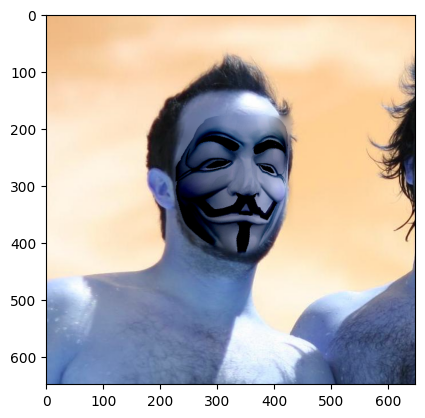

In [62]:
image = cv.imread("/kaggle/input/ibug-300w-large-face-landmark-dataset/ibug_300W_large_face_landmark_dataset/helen/trainset/100040721_2.jpg")
filter_image = cv.imread("/kaggle/input/mask-joker/joker.jfif")

image_filter = filterApp.filter_image(img=image, filter=filter_image)
plt.imshow(image_filter)
plt.show()

In [55]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.
